In [1]:
import json
import pathlib

import matplotlib.ticker
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

from hubbardml import datasets
from hubbardml import keys
from hubbardml import plots

import olivines

/tmp/ipykernel_3709349/1077300395.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# EXPERIMENT_DIR = pathlib.Path(
#     "outputs/train.batch_size=32,train.max_epochs=4000/2023-07-27_14-28-01"
# )
# EXPERIMENT_DIR = pathlib.Path(
#     "outputs/train.batch_size=16,train.max_epochs=10000/2023-07-28_15-29-57"
# )
# EXPERIMENT_DIR = pathlib.Path(
#     "outputs/train.batch_size=1024,train.max_epochs=10000/2023-08-08_09-55-09"
# )
EXPERIMENT_DIR = pathlib.Path(
    "outputs/olivines/train.batch_size=1024,train.max_epochs=20000/2023-08-10_10-33-42"
)
EXPERIMENT_DIR = pathlib.Path(
    "outputs/olivines/train.batch_size=32,train.max_epochs=20000/2023-08-10_22-53-27"
)
EXPERIMENT_DIR = pathlib.Path(
    "outputs/olivines/batch_size=64,max_epochs=12000/2023-08-20_21-47-51"
)
# EXPERIMENT_DIR = pathlib.Path(
#     "outputs/olivines/batch_size=32,max_epochs=12000/2023-08-21_10-38-09"
# )
EXPERIMENT_DIR = pathlib.Path(
    "outputs/olivines/batch_size=32,max_epochs=12000/2023-08-22_13-43-01"
)
EXPERIMENT_DIR = pathlib.Path(
    "outputs/olivines/batch_size=16,max_epochs=12000/2023-08-25_15-47-48"
)
EXPERIMENT_DIR = pathlib.Path(
    "outputs/olivines/batch_size=8,max_epochs=12000/2023-08-27_12-03-46"
)
EXPERIMENT_DIR = pathlib.Path(
    "outputs/olivines/batch_size=8,max_epochs=6000/2024-03-05_11-58-26"
)


DATASET = "dataset.json"
RESULTS_FILE = "hubbard_u_olivines.json"

In [3]:
uv_data = pd.read_json(EXPERIMENT_DIR / DATASET)
labels = {
    'LiFePO4': 'Li$_{x}$FePO$_4$',
    'LiMnPO4': 'Li$_{x}$MnPO$_4$',
    "LiFe0.5Mn0.5PO4": "Li$_{x}$Fe$_{0.5}$Mn$_{0.5}$PO$_4$",
}
uv_data

,dir,material,is_vdw,uv_iter,formula,cell,n_atoms_uc,person,structure_index,pw_time_unix,...,atom_2_occs_2,atom_2_frac_coords,atom_2_starting_mag,atom_2_final_mag,param_delta,species,label,colour,sc_paths,occupation
301432,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,A1_Li0.00Mn0.5Fe0.5PO4,False,1,,"[18.5936265225, -0.0009754750000000001, 0.0072...",24,iurii,156,1618231488,...,"[[0.997, 0.0, 0.0, 0.0, 0.0], [0.0, 0.992, 0.0...","[-0.0073431, -0.00041139999999999997, -0.01556...",0.0,-3.9118,-0.1663,[Fe],Fe,#E06633,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,0.0
301534,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,A1_Li0.00Mn0.5Fe0.5PO4,False,1,,"[18.5936265225, -0.0009754750000000001, 0.0072...",24,iurii,156,1618231488,...,"[[0.092, 0.014, 0.0, -0.006, 0.0], [0.014, 0.1...","[-0.056849399999999994, 0.4995747, -0.51556099...",0.0,3.9077,-0.0563,[Fe],Fe,#E06633,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,0.0
301654,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,A1_Li0.00Mn0.5Fe0.5PO4,False,1,,"[18.5936265225, -0.0009754750000000001, 0.0072...",24,iurii,156,1618231488,...,"[[0.991, -0.033, 0.0, -0.039, 0.0], [-0.033, 0...","[0.5048417, -0.0004909, -0.39822029999999997]",0.0,-3.4365,0.9313,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,0.0
301774,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,A1_Li0.00Mn0.5Fe0.5PO4,False,1,,"[18.5936265225, -0.0009754750000000001, 0.0072...",24,iurii,156,1618231488,...,"[[0.048, -0.008, 0.0, 0.016, 0.0], [-0.008, 0....","[0.43096, 0.4996846, -0.8981882999999999]",0.0,3.4364,0.9315,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,0.0
303650,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,A1_Li0.00Mn0.5Fe0.5PO4,False,2,,"[18.577492166, -0.0007413610000000001, 0.00680...",24,iurii,157,1618391955,...,"[[0.997, 0.0, 0.0, 0.0, 0.0], [0.0, 0.991, 0.0...","[-0.0069193, -0.00040439999999999996, -0.01602...",0.0,-3.8419,0.1001,[Fe],Fe,#E06633,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiFe0...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438732,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B5_Li1.00MnPO4,False,3,,"[19.7940850765, 0.0, 0.0, 0.0, 11.511736551, 0...",28,iurii,218,1594749234,...,"[[0.996, -0.001, 0.0, -0.001, 0.0], [-0.001, 0...","[0.4372178, 0.5, -0.9466146]",0.0,-4.2040,0.1188,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,1.0
440618,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B5_Li1.00MnPO4,False,4,,"[19.7940850765, 0.0, 0.0, 0.0, 11.511736551, 0...",28,iurii,219,1595848609,...,"[[0.02, 0.002, 0.0, 0.006, 0.0], [0.002, 0.057...","[-0.001527, 0.0, 0.0021371999999999997]",0.0,4.2058,-0.0129,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,1.0
440720,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B5_Li1.00MnPO4,False,4,,"[19.7940850765, 0.0, 0.0, 0.0, 11.511736551, 0...",28,iurii,219,1595848609,...,"[[0.02, -0.002, 0.0, 0.006, 0.0], [-0.002, 0.0...","[0.4984724, 0.0, -0.4466148]",0.0,4.2058,-0.0129,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,1.0
440840,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,B5_Li1.00MnPO4,False,4,,"[19.7940850765, 0.0, 0.0, 0.0, 11.511736551, 0...",28,iurii,219,1595848609,...,"[[0.996, 0.001, 0.0, -0.001, 0.0], [0.001, 0.9...","[-0.06278249999999999, 0.5, -0.4978627]",0.0,-4.2058,-0.0129,[Mn],Mn,#9C7AC7,/Users/azadoks/Data/uv_ml/iurii/Olivines/LiMnP...,1.0


In [4]:
uv_data[uv_data[keys.PARAM_TYPE] == keys.PARAM_V].groupby(keys.MATERIAL).value_counts([olivines.Keys.OCCUPATION])

Series([], Name: count, dtype: int64)

In [5]:
sum(uv_data[keys.PARAM_OUT] < 0.25)

0

In [6]:
def create_plots(df: pd.DataFrame, logy=False, scale=1.0):
    comparison_plots = {}

    if olivines.Keys.TRAIN_RMSE in df:
        cols = [olivines.Keys.TRAIN_RMSE, olivines.Keys.MODEL_RMSE]
        series_labels = 'ML (train)', 'ML (validate)'
    else:
        cols = [olivines.Keys.MODEL_RMSE]
        series_labels = ('ML (validate)',)

    for material in df[olivines.Keys.MATERIAL].unique():
        frame = df[df[olivines.Keys.MATERIAL] == material]
        ref_rmse = frame.iloc[0][olivines.Keys.REF_RMSE]  # They are all the same

        grouped = frame.groupby(olivines.Keys.NUM_OCCUPATIONS)[cols]
        mins = grouped.min()
        maxs = grouped.max()
        means = grouped.mean()

        errors = [[means[c] - mins[c], maxs[c] - means[c]] for c in cols]

        fig = plt.figure(figsize=(6 * scale, 4 * scale))
        ax = fig.gca()

        ax = means.plot(
            ax=ax,
            # colormap=plots.colourmap,
            color=plots.train_validate_colours.values(),
            yerr=errors,
            fmt='o--',
            logy=logy,
            solid_capstyle='projecting',
            capsize=5,
            capthick=2,
            title=labels[material],
            # linewidth=3,
            # alpha=0.5,
            ylabel='RMSE (eV)',
            xlabel='Num. training occupations',
        );

        # Plot the baseline RMSE
        ax.plot(
            [df[olivines.Keys.NUM_OCCUPATIONS].min(),
             df[olivines.Keys.NUM_OCCUPATIONS].max()],
            [ref_rmse, ref_rmse],
            c=plots.train_validate_colours[keys.REFERENCE]
        )

        ax.legend((f"Ref {ref_rmse * 1000:.0f} meV",) + series_labels)
        ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
        # ax.set_ylim([0, 1.2])

        comparison_plots[material] = ax

    return comparison_plots

# Olivines analysis

In [7]:
results_file = EXPERIMENT_DIR / RESULTS_FILE
with open(results_file, 'r') as file:
    hubbard_u_olivines = pd.DataFrame(json.load(file))
hubbard_u_olivines;

In [8]:
save_to = EXPERIMENT_DIR / "plots"
save_to.mkdir(exist_ok=True)
save_to

PosixPath('outputs/olivines/batch_size=8,max_epochs=6000/2024-03-05_11-58-26/plots')

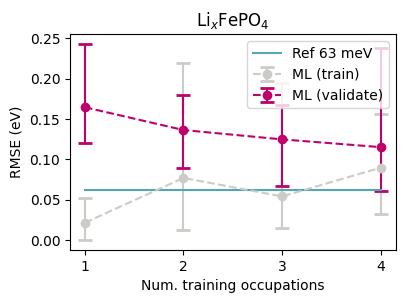

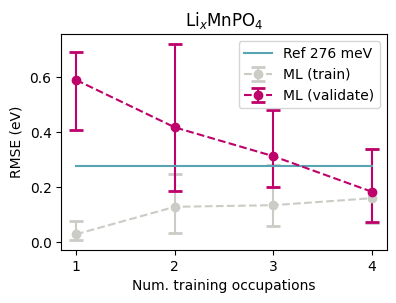

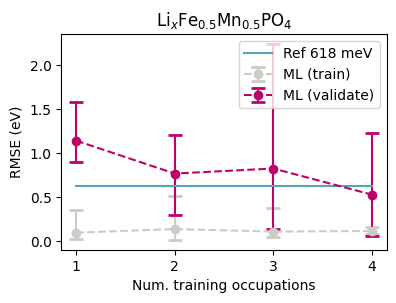

In [9]:
for material, ax in create_plots(hubbard_u_olivines, scale=0.7).items():
    ax.get_figure().savefig(save_to / f"{material}_U_occs_comparison.pdf", bbox_inches='tight')

In [10]:
results_file = 'hubbard_v_olivines.json'
with open(results_file, 'r') as file:
    hubbard_v_olivines = pd.DataFrame(json.load(file))

for material, ax in create_plots(hubbard_v_olivines, logy=True, scale=0.7).items():
    ax.get_figure().savefig(save_to / "f{material}_V_occs_comparison.pdf", bbox_inches='tight')
    
save_to

FileNotFoundError: [Errno 2] No such file or directory: 'hubbard_v_olivines.json'

In [ ]:
for material in olivines.MATERIALS:
    print(material)
    subset = uv_data[uv_data[keys.DIR].str.contains(material)]
    elements = subset[keys.ATOM_1_ELEMENT].unique()
    
    for element in elements:
        elementsubset = subset[subset[keys.ATOM_1_ELEMENT] == element]
        minval = elementsubset[keys.PARAM_OUT].min()
        maxval = elementsubset[keys.PARAM_OUT].max()
        stdev = elementsubset[keys.PARAM_OUT].std()

        meanval = elementsubset[keys.PARAM_OUT].mean()
        print(len(elementsubset), element, minval, maxval, meanval, stdev)
        

In [ ]:
olivines.MATERIALS

In [ ]:
ds = pd.read_json(EXPERIMENT_DIR / "LiMnPO4_2_0.25-0.50" / DATASET)

In [ ]:
def relative_error(row):
    return np.abs((row[keys.PARAM_OUT_PREDICTED] - row[keys.PARAM_OUT]) / row[keys.PARAM_OUT]) 


ds[ds[keys.TRAINING_LABEL] == keys.VALIDATE].apply(relative_error, axis=1).hist()